# create fake BOLD signal via audio envelope
## (for testing the unscrambling functions and procedure)


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
from scipy import stats
from scipy import signal
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import scipy.io
np.set_printoptions(threshold=np.nan)

import os
import copy
%load_ext autotime

In [3]:
#hrf function

from scipy.stats import gamma
def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times,12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6

time: 13.4 ms


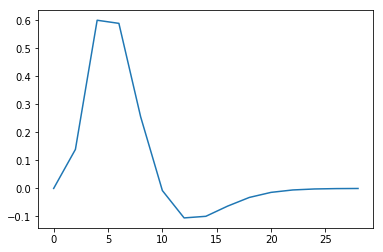

time: 183 ms


In [4]:
TR =2
tr_times = np.arange(0, 30, TR)
hrf_at_trs = hrf(tr_times)
len(hrf_at_trs)
plt.plot(tr_times, hrf_at_trs)

In [5]:
#set segment duration in ms (based on parachute data)
duration = [26582,17753,20779,19543,22929,19147,22160,23415,20391,21923,26193,19517,15408,17716,15475,\
            15406,25344,28487,29716,18088,17271,29857,24453,24342,24442]
duration_datascram = [np.round(x/1500) for x in duration] #duration in TRs
duration_datascram = np.asarray(duration_datascram)
duration_datascram = duration_datascram.astype(int)
duration_20ms = [np.round(x/20) for x in duration] #downsampled to 20ms (50Hz)
duration_20ms = np.asarray(duration_20ms)
duration_20ms = duration_20ms.astype(int)

time: 18.2 ms


In [6]:
#reorder intact duration to longscram duration (and vice versa)
order_it2ls=[4,23,8,24,18,7,0,17,22,16,2,12,15,9,20,13,5,14,11,19,6,21,1,10,3] 
order_ls2it = [6,22,10,24,0,16,20,5,2,13,23,18,11,15,17,12,9,7,4,19,14,21,8,1,3]
order_it2ls2= [4,5,24,9,0,19,8,1,18,23,17,3,13,16,10,21,14,6,15,12,20,7,22,2,11] 
duration_ls = [duration_20ms[j] for j in order_it2ls]
print('duration longscram is:',duration_ls) 
duration_it_new = [duration_20ms[j] for j in order_it2ls2]
print('duration new it is:',duration_it_new) #reorder intact segments for AB-AC analysis

duration longscram is: [1146, 1217, 1020, 1222, 1486, 1171, 1329, 1424, 1223, 1267, 1039, 770, 770, 1096, 864, 886, 957, 774, 976, 904, 1108, 1493, 888, 1310, 977]
duration new it is: [1146, 957, 1222, 1096, 1329, 904, 1020, 888, 1486, 1217, 1424, 977, 886, 1267, 1310, 1493, 774, 1108, 770, 770, 864, 1171, 1223, 1039, 976]
time: 24.1 ms


In [7]:
#create fake audio data [5 frequency channel by 365 time points] 
f=5
t=365
s_it = abs(np.random.normal(0,1,[f,t]))
print('shape of the fake fMRI signal:',np.shape(s_it))

shape of the fake fMRI signal: (5, 365)
time: 5.67 ms


In [8]:
#scramble the audio data to make a long-scrambled version
i=0
s_origin = []
for j in range(len(duration_datascram)):
    s_origin.append(s_it[:,i:i+duration_datascram[j]]) 
    i=i+duration_datascram[j]
s_ls = [s_origin[j] for j in order_it2ls] #generate the longscram data
s_ls = np.hstack(s_ls)

time: 7.27 ms


In [9]:
#generate fMRI data from multiplying audio data (i.e. matrix s) with voxel activity (i.e. matrix w)
def data_generation(s,w):
    n, t = np.shape(s)
    R = np.matmul(w,s) 
    return R

time: 3.16 ms


In [10]:
#average voxel activation to find time course
def find_time_course(data):
    tc=[]
    n, v_a1, t = np.shape(data)
    for s in range(n):
        tc.append(np.mean(data[s,:,:],0))
        
    tc=np.asarray(tc)
        
    return tc

time: 9.42 ms


In [11]:
#upsampling datapoints across time in each voxel 
def voxel_upsampling(data, upsampling_datapoints):
    resam = []
    n_sbj, voxel, time = np.shape(data)
    for s in range(n_sbj):
        sbj=[]
        for v in range(voxel):
            sbj.append(signal.resample(data[s,v,:],upsampling_datapoints))
        resam.append(sbj)
        
    resam = np.asarray(resam)

    return resam


time: 16.9 ms


In [12]:
#convolving data with HRF effect
def HRF_convolve(time_course,hrf_at_trs):

    convolved = np.convolve(time_course, hrf_at_trs)
    n_to_remove = len(hrf_at_trs) - 1
    convolved = convolved[:-n_to_remove]
        
    return convolved

time: 5.48 ms


In [15]:
#generate fake subjects for intact and long-scramble group
R_it=[]
R_ls=[]
n_sbj=10  #set number of fake subjects
n_voxels=4  #set number of voxels
w = abs(np.random.normal(0,1,[n_voxels,f]))
voxel, time = np.shape(data_generation(s_it,w))
noise_level=0
it_data=data_generation(s_it,w) #generate data from the fMRI model (audio stimulus x brain activation)
ls_data=data_generation(s_ls,w)


for i in range(n_sbj):
    r_it=[]
    r_ls=[]
    noise = np.random.normal(0,noise_level,[voxel,time])
    it_noise=it_data+noise #adding random noise to data
    noise = np.random.normal(0,noise_level,[voxel,time])
    ls_noise=ls_data+noise
    for v in range(voxel):
#         convolved_it = HRF_convolve(it_noise[v],hrf_at_trs) #convolved with HRF
#         convolved_ls = HRF_convolve(ls_noise[v],hrf_at_trs)
        convolved_it = it_noise[v]
        convolved_ls = ls_noise[v]
        r_it.append(convolved_it-np.mean(convolved_it))
        r_ls.append(convolved_ls-np.mean(convolved_ls))
    R_it.append(r_it)
    R_ls.append(r_ls)
    

R_it= np.asarray(R_it)
R_ls= np.asarray(R_ls)

print("shape of the fake BOLD data:",np.shape(R_it))


shape of the fake BOLD data: (10, 4, 365)
time: 67.6 ms


In [16]:
# convolved with HRF?
# R_it=HRF_convolve(R_it)
# R_ls=HRF_convolve(R_ls)
# R_it=np.asarray(R_it)
# R_ls=np.asarray(R_ls)

time: 2.15 ms


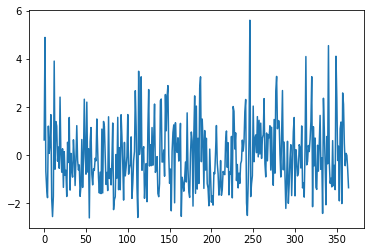

time: 273 ms


In [17]:
plt.plot(R_it[0][0])

In [18]:
#upsampling the BOLD signal along the time (to 50Hz, or the sum of the duration_20ms)
R_it=voxel_upsampling(R_it,sum(duration_20ms))
R_ls=voxel_upsampling(R_ls,sum(duration_20ms))

time: 1.09 s


In [20]:
#find time course
R_it_tc=find_time_course(R_it)
R_ls_tc=find_time_course(R_ls)

time: 16.6 ms


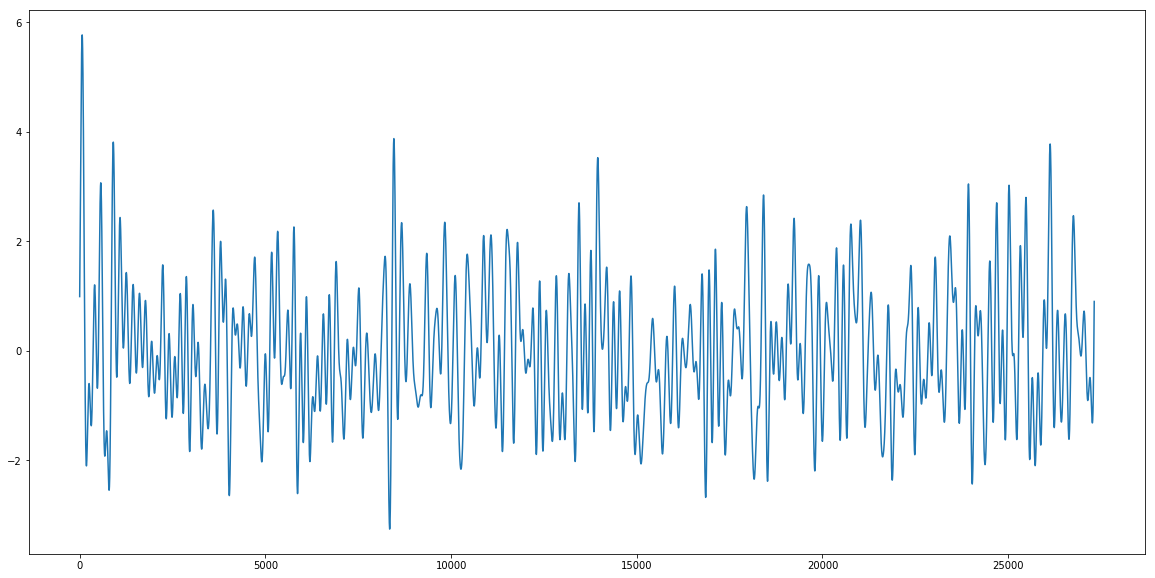

time: 455 ms


In [21]:
#visualize the time course
plt.figure(figsize=(20,10))
plt.plot(np.mean(R_it_tc,0))
plt.show()

In [22]:
#parsing (and unscramble) the timecourse data
def parsing_unscrambling_tc(data, order_ls2it, duration): #set order_ls2it=0 if no unscrambling
    n=np.shape(data)[0]
    ul_all=[]
    for s in range(n):
        ul_seg=[]
        i=0
        for j in range(len(duration)):
            ul_seg.append(data[s,i:i+duration[j]])   #parse the longscram data
            i=i+duration[j]

        if order_ls2it!=0:
            ul_seg = [ul_seg[j] for j in order_ls2it] #unscramble the longscram data
        ul_ravel = np.concatenate(ul_seg).ravel()        
        ul_all.append(ul_ravel)
    ul_all=np.asarray(ul_all)
        
    return ul_all

time: 29.6 ms


In [23]:
#parsing (and unscramble) the time*voxel data
def parsing_unscrambling(data, order_ls2it, duration): #set order_ls2it=0 if no unscrambling
    n,voxel, time=np.shape(data)
    ul_all=[]
    for s in range(n):
        ul_seg=[]
        for v in range(voxel):
            i=0
            ul_seg_voxel=[]
            for j in range(len(duration)):
                ul_seg_voxel.append(data[s,v,i:i+duration[j]])   #parse the longscram data
                i=i+duration[j]
            if order_ls2it!=0:
                ul_seg_voxel = [ul_seg_voxel[j] for j in order_ls2it] #unscramble the longscram data
            ul_ravel = np.concatenate(ul_seg_voxel).ravel()        
            ul_seg.append(ul_ravel)  
        ul_all.append(ul_seg)
    ul_all=np.asarray(ul_all)
           
    return ul_all

time: 37.6 ms


In [24]:
#parsing and unscrambling tc
R_it_tc_all=parsing_unscrambling_tc(R_it_tc,0, duration_20ms)  
R_uls_tc_all=parsing_unscrambling_tc(R_ls_tc, order_ls2it, duration_ls)

#examine the correlation between intact and unscvrambled data
print("corr between intact and unscrambled data:",np.corrcoef(R_it_tc_all[0],R_uls_tc_all[0])[0,1]) 

corr between intact and unscrambled data: 0.454600751804
time: 27.2 ms


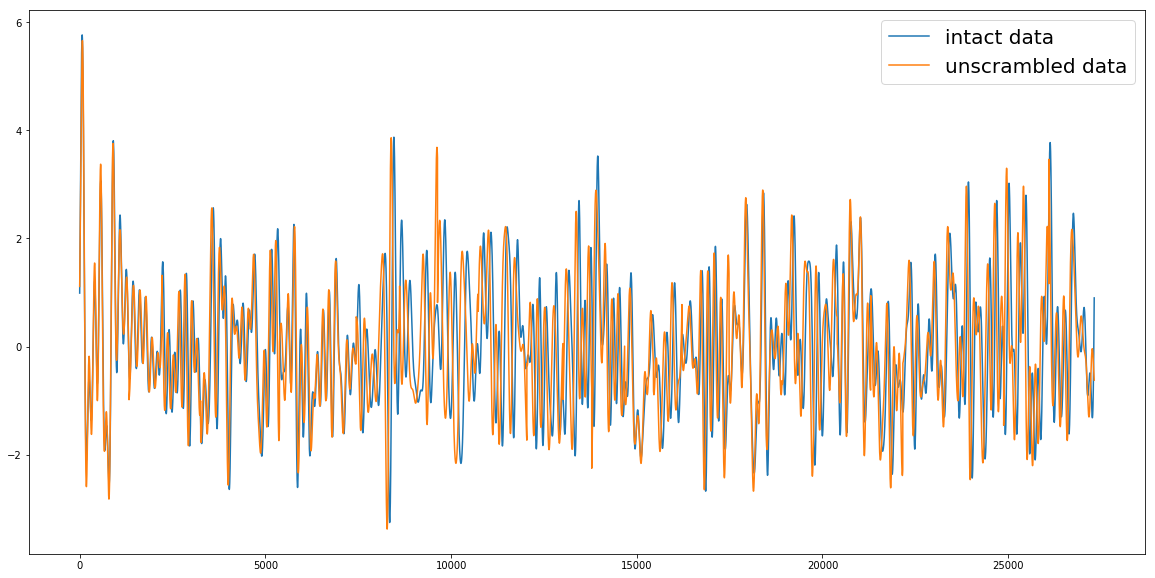

time: 550 ms


In [25]:
#visualize the intact and unscrambled data
plt.figure(figsize=(20,10))
plt.plot(R_it_tc_all[0], label="intact data")
plt.plot(R_uls_tc_all[0], label="unscrambled data")
plt.legend(fontsize=20)
plt.show()

In [26]:
# inter-subject temporal correlation (ISC) analysis

def ISTC(it_data, uls_data, start_time, end_time, duration): #start and end time within events
    n, time=np.shape(it_data)
    ind=np.arange(n)
    rII,rUU,rUI,rIU=([]for i in range(4))
    r_tc_rII,r_tc_rUU,r_tc_rUI,r_tc_rIU=([]for i in range(4)) 
    for s in range(n):
        a = ind[np.arange(len(ind))!= s]
        i=0
        r_seg_rII,r_seg_rUU,r_seg_rUI,r_seg_rIU=([]for i in range(4))
        for seg in duration: #calculate rII for each segment based on the startnig point of segment duration
            other_rII = np.mean(it_data[a,i+start_time:i+end_time],0)
            r_seg_rII.append(np.corrcoef(other_rII,it_data[s,i+start_time:i+end_time])[0][1])
            i = i + seg
        i=0
        for seg in duration: #calculate rUU
            other_rUU = np.mean(uls_data[a,i+start_time:i+end_time],0)
            r_seg_rUU.append(np.corrcoef(other_rUU,uls_data[s,i+start_time:i+end_time])[0][1])
            i = i + seg
        i=0
        for seg in duration: #calculate rUI
            other_rUI = np.mean(it_data[:,i+start_time:i+end_time],0)
            r_seg_rUI.append(np.corrcoef(other_rUI,uls_data[s,i+start_time:i+end_time])[0][1])
            i = i + seg
        i=0
        for seg in duration: #calculate rIU
            other_rIU = np.mean(uls_data[:,i+start_time:i+end_time],0)
            r_seg_rIU.append(np.corrcoef(other_rIU,it_data[s,i+start_time:i+end_time])[0][1])
            i = i + seg
        

        r_tc_rII.append(r_seg_rII)
        r_tc_rUU.append(r_seg_rUU)
        r_tc_rUI.append(r_seg_rUI)
        r_tc_rIU.append(r_seg_rIU)
               
    rII=np.mean(r_tc_rII,0)
    rUU=np.mean(r_tc_rUU,0)
    rUI=np.mean(r_tc_rUI,0)
    rIU=np.mean(r_tc_rIU,0)
    
    return rII, rUU, rUI, rIU


time: 219 ms


In [27]:
trII, trUU, trUI, trIU=ISTC(R_it_tc_all, R_uls_tc_all, 0, 450, duration_20ms)

time: 164 ms


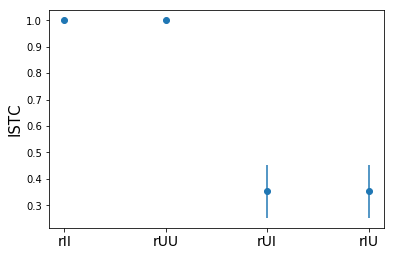

time: 169 ms


In [28]:
#visulize the average ISC for rII, rUU, rUI and rIU
plt.errorbar(np.arange(4),[np.mean(trII), np.mean(trUU), np.mean(trUI),np.mean(trIU)],\
             yerr=[stats.sem(trII), stats.sem(trUU), stats.sem(trUI),stats.sem(trIU)], fmt='o', label='A1')
plt.xticks(np.arange(4),['rII','rUU','rUI','rIU'], fontsize=14)
plt.ylabel('ISTC', fontsize=15)
plt.show()

In [29]:
#unscrambling patter for AB-AC
R_it_all=parsing_unscrambling(R_it,order_it2ls2, duration_20ms) #reorder intact duration for AB-AC analysis
R_uls_all=parsing_unscrambling(R_ls, 0, duration_ls)

time: 39.4 ms


In [30]:
# inter-subject pattern correlation (ISPC) analysis

def ISPC(it_data, uls_data, start_time, end_time, duration_it, duration_ul): #start and end time within events
    n, voxel, time=np.shape(it_data)
    ind=np.arange(n)
    r_pc_rII,r_pc_rUU,r_pc_rUI,r_pc_rIU=([]for i in range(4)) 
    for s in range(n):
        print('sbj:',s)
        a = ind[np.arange(len(ind))!= s]
        r_seg_rII,r_seg_rUU,r_seg_rUI,r_seg_rIU=([]for i in range(4)) 
        i=0
        j=0
        for l in range(np.shape(duration_it)[0]): 
            if duration_it[l] > end_time and duration_ul[l] > end_time:
                r=[]
                for t in range(start_time, end_time):
                    other_rII = np.mean(it_data[a,:,i+t],0)
                    r.append(np.corrcoef(other_rII,it_data[s,:,i+t])[0][1])
                r_seg_rII.append(r)

                r=[]
                for t in range(start_time, end_time):
                    other_rUU = np.mean(uls_data[a,:,j+t],0)
                    r.append(np.corrcoef(other_rUU,uls_data[s,:,j+t])[0][1])
                r_seg_rUU.append(r)

                r=[]
                for t in range(start_time, end_time):
                    other_rUI = np.mean(it_data[:,:,i+t],0)
                    r.append(np.corrcoef(other_rUI,uls_data[s,:,j+t])[0][1])
                r_seg_rUI.append(r)

                r=[]
                for t in range(start_time, end_time):
                    other_rIU = np.mean(uls_data[:,:,j+t],0)
                    r.append(np.corrcoef(other_rIU,it_data[s,:,i+t])[0][1])
                r_seg_rIU.append(r)                
            i = i + duration_it[l]
            j = j + duration_ul[l]

        r_pc_rII.append(r_seg_rII)
        r_pc_rUU.append(r_seg_rUU)
        r_pc_rUI.append(r_seg_rUI)
        r_pc_rIU.append(r_seg_rIU)
        print(np.shape(r_pc_rII))
    rII = np.mean(r_pc_rII,0)
    rUU = np.mean(r_pc_rUU,0)
    rUI = np.mean(r_pc_rUI,0)
    rIU = np.mean(r_pc_rIU,0)
    
    return rII, rUU, rUI, rIU



time: 198 ms


In [79]:
rII, rUU, rUI, rIU=ISPC(R_it_all, R_uls_all, 0, 800, duration_it_new,duration_ls)

sbj: 0
(1, 19, 800)
sbj: 1
(2, 19, 800)
sbj: 2
(3, 19, 800)
sbj: 3
(4, 19, 800)
sbj: 4
(5, 19, 800)
sbj: 5
(6, 19, 800)
sbj: 6
(7, 19, 800)
sbj: 7
(8, 19, 800)
sbj: 8
(9, 19, 800)
sbj: 9
(10, 19, 800)
time: 56.4 s


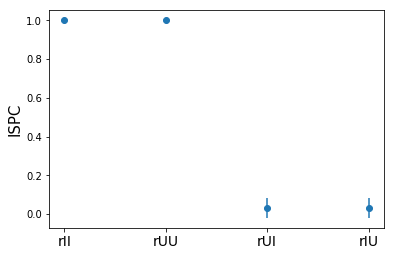

time: 156 ms


In [80]:
#visulize the average ISPC for rII, rUU, rUI and rIU
start=0
end=800
plt.errorbar(np.arange(4),[np.mean(rII[:,start:end]), np.mean(rUU[:,start:end]), np.mean(rUI[:,start:end]),np.mean(rIU[:,start:end])], \
             yerr=[stats.sem(np.mean(rII[:,start:end],1)),stats.sem(np.mean(rUU[:,start:end],1)),stats.sem(np.mean(rUI[:,start:end],1)),\
                   stats.sem(np.mean(rIU[:,start:end],1))],label='A1',fmt='o')
plt.xticks(np.arange(4),['rII','rUU','rUI', 'rIU'], fontsize=14)
plt.ylabel('ISPC', fontsize=15)
plt.show()

# Checking data alignment with real fMRI data (from A1)

In [31]:
import os
import copy
from scipy import stats

def load_data(path):
    data = scipy.io.loadmat(path)
    BOLD = copy.deepcopy(data['rdata'])
    voxel, time = np.shape(BOLD)
    mean_t=np.mean(BOLD,1)
    for t in range(time):        
        for i in range(len(mean_t)):
            BOLD[i,t] = BOLD[i,t] - mean_t[i]            
    
    return BOLD


time: 18.6 ms


In [32]:
#loading fMRI data in A1+
name_intact = 'MSS_173031','MMX_174331','JKF_181331','JFQ_181531','JEX_181531','JQM_191331','JLN_192031',\
'SBX_213031','MBX_172331','JFX_181531','JBU_181531','JHS_183431',    'JFG_183631','JEQ_183731','JEO_184131',\
'NOT_231331','NWS_231831','NMA_231931', 'NTE_232031','NUH_232131','NED_232431','JSC_193231',\
'AUU_161536','DSC_243135','DSQ_243135','FTT_141336','JKI_182236','JUL_181336','MBM_174336',\
'MCE_173536','MTL_173536'
name_ROIs = 'a1_rev'
    
it_BOLD_sbj = [] 
for n in name_intact:
    path_it = os.path.join('/Users/sherrychien/Desktop/mont2/parachute/subjects',n,'notthefall_intact')
    path_ROI_it = os.path.join(path_it,'%s_trans_filtered_func_data.mat'%name_ROIs)
    data = load_data(path_ROI_it)[:,:390]

    it_BOLD_sbj.append(data)

#Longscram data info
name_ls = 'JSC_193231','JNB_193231','ANT_201531','AFI_201731','AKT_202131','ATE_203131','SLC_212531','OTA_222031',\
'JTH_193431','JGT_194031','ADI_201431','AHQ_201531','AEH_203631','SLT_212131','SQT_212731','SCE_212731',\
'OKX_222031','OMT_222431','OFO_223331','NTN_231731','DSN_241831','DEY_242731','AUU_161536','DSC_243135',\
'DSQ_243135','FTT_141336','JKI_182236','JUL_181336','MBM_174336','MCE_173536','MTL_173536'

ls_BOLD_sbj = [] 
for n in name_ls:
    path_ls = os.path.join('/Users/sherrychien/Desktop/mont2/parachute/subjects',n,'notthefall_longscram')
    path_ROI_ls = os.path.join(path_ls,'%s_trans_filtered_func_data.mat'%name_ROIs)
    data = load_data(path_ROI_ls)[:,:390]

    ls_BOLD_sbj.append(data)

time: 1min 52s


In [33]:
# transfer data to numpy array
it_BOLD_sbj=np.asarray(it_BOLD_sbj)
ls_BOLD_sbj=np.asarray(ls_BOLD_sbj)

#upsampling the data from 390 TRs to 29250 time points(20ms base)
upsampling_datapoints=29250
A1_it_resam=voxel_upsampling(it_BOLD_sbj, upsampling_datapoints)
A1_ls_resam=voxel_upsampling(ls_BOLD_sbj, upsampling_datapoints)

time: 32.6 s


In [34]:
#average voxel data to get time course of the signal 
A1_it_tc = find_time_course(A1_it_resam)
A1_ls_tc = find_time_course(A1_ls_resam)


time: 2.23 s


In [35]:
#align subjects' A1 signal
def sbj_align(data, start, end):
    shift=[]
    n_sbj, time = np.shape(data)
    ind=np.arange(n_sbj)
    for s in range(n_sbj):
        a = ind[np.arange(len(ind))!= s] 
        c = np.correlate(data[s,start:end], np.mean(data[a,start:end],0),'same')
        shift.append(np.argmax(c)-int((end-start)/2)) #find the maximum correlation between one subject and the mean of the rest subjects
    print(shift) #the shift for each subject
    shift=np.asarray(shift)
    
    return shift


time: 18.6 ms


In [36]:
#align subjects in the intact group (shifting for three times)
shift = sbj_align(A1_it_tc, 1275, 28875)
#the intro music is 1275*20ms. 28875 is the length of the audio stimuli (including music)
tc_crop=[]
n_sbj,time=np.shape(A1_it_tc)
for s in range(n_sbj):
    tc_crop.append(A1_it_tc[s,1275+shift[s]:28875+shift[s]])
tc_crop=np.asarray(tc_crop)

shift1 = sbj_align(tc_crop, 0, 27600)
tc_crop1=[]
for s in range(n_sbj):
    tc_crop1.append(A1_it_tc[s,1275+shift[s]+shift1[s]:28875+shift[s]+shift1[s]])
tc_crop1=np.asarray(tc_crop1)

shift2 = sbj_align(tc_crop1, 0, 27600)
tc_crop2=[]
for s in range(n_sbj):
    tc_crop2.append(A1_it_tc[s,1275+shift[s]+shift1[s]+shift2[s]:28875+shift[s]+shift1[s]+shift2[s]])
tc_crop2=np.asarray(tc_crop2)

[-17, 10, 11, 45, -21, -29, 10, -22, -4, 1, -16, 9, -8, 3, -16, 57, -26, 14, -7, 25, 11, 18, -149, 2, 26, 50, 17, 26, 0, -126, -236]
[0, 0, 0, -6, -2, -1, -1, 1, 0, -3, -1, 0, -1, 0, 2, 0, 2, 0, 1, 4, 0, 0, 2, 2, -3, 0, 0, 0, -1, -1, 7]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0]
time: 18.4 s


In [37]:
#align subjects in the longscram group (shifting for three times)
shift_ls = sbj_align(A1_ls_tc, 1275, 28875)
tc_crop_ls=[]
for s in range(n_sbj):
    tc_crop_ls.append(A1_ls_tc[s,1275+shift_ls[s]:28875+shift_ls[s]])
tc_crop_ls=np.asarray(tc_crop_ls)

shift1_ls = sbj_align(tc_crop_ls, 0, 27600)
tc_crop1_ls=[]
for s in range(n_sbj):
    tc_crop1_ls.append(A1_ls_tc[s,1275+shift_ls[s]+shift1_ls[s]:28875+shift_ls[s]+shift1_ls[s]])
tc_crop1_ls=np.asarray(tc_crop1_ls)


shift2_ls = sbj_align(tc_crop1_ls, 0, 27600)
tc_crop2_ls=[]
for s in range(n_sbj):
    tc_crop2_ls.append(A1_ls_tc[s,1275+shift_ls[s]+shift1_ls[s]+shift2_ls[s]:28875+shift_ls[s]+shift1_ls[s]+shift2_ls[s]])
tc_crop2_ls=np.asarray(tc_crop2_ls)

[18, 51, 45, -13, 49, -38, -14, -16, -1, -9, -10, 22, 10, 0, -15, 21, -1, -211, 21, -2, 1, 0, -297, 3, 20, 29, 19, 21, 3, -141, -167]
[0, -5, -1, 0, 0, 1, -2, 0, 1, 0, 4, 0, 1, 2, 0, 0, 1, -48, 3, 0, 3, 0, -10, 0, 0, 0, -2, 0, 0, 0, 0]
[0, 2, -1, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, -1, 0]
time: 17.7 s


In [40]:
#load audio envelope (which has been downsampled to 50Hz)
path = os.path.join('/Users/sherrychien/Desktop/mont3/sherry/parachute/stimuli/parachute_intact_audenv.mat')
a1 = scipy.io.loadmat(path)
env_intact=np.reshape(a1['audenv'],((28875)))
audioenv_intact= env_intact[1275:] #remove the music part
path = os.path.join('/Users/sherrychien/Desktop/mont3/sherry/parachute/stimuli/parachute_longscram_audenv.mat')
a1 = scipy.io.loadmat(path)
env_ls=np.reshape(a1['audenv'],((28875)))
audioenv_ls= env_ls[1275:]

time: 427 ms


In [41]:
#convolve the audio envolop with HRF (TR=20ms)
TR =0.02
tr_times = np.arange(0, 30, TR)
hrf_at_trs = hrf(tr_times)
convolved_it = np.convolve(env_intact, hrf_at_trs)
convolved_ls = np.convolve(env_ls, hrf_at_trs)

all_tr_times = np.arange(28875) * TR
n_to_remove = len(hrf_at_trs) - 1
convolved_it = convolved_it[:-n_to_remove]
convolved_ls = convolved_ls[:-n_to_remove]

time: 58 ms


intact shift: 131
ls shift: 139


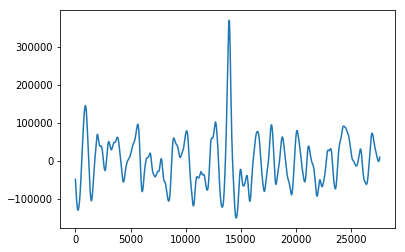

time: 621 ms


In [42]:
#find the maximum corr between data and HRF-convolved audio signal
# intact cross correlation with intact audio envelope (with HRF)
xcorr = np.correlate(np.mean(tc_crop2[:,:27600],0),stats.zscore(convolved_it[1275:28875]),'same')
mean_shift_intact=np.argmax(xcorr)-13800
print ("intact shift:",mean_shift_intact)

# long-scram data cross correlation with scrambled audio envelope (with HRF)
xcorr = np.correlate(np.mean(tc_crop2_ls[:,:27600],0),stats.zscore(convolved_ls[1275:28875]),'same')
mean_shift_ls=np.argmax(xcorr)-13800
print ("ls shift:",mean_shift_ls)

plt.plot(xcorr)
plt.show()

In [43]:
#cropping fMRI data based on the between-subject and audio alignment 
#***save the shifts (get from A1) for analyzing other ROIs***
shift_it_total=shift+shift1+shift2+mean_shift_intact
shift_ls_total=shift_ls+shift1_ls+shift2_ls+mean_shift_ls
def cropping_tc(data, shift):
    n_sbj,time=np.shape(data)
    data_cropped=[]
    for s in range(n_sbj):
        data_cropped.append(data[s,1275+shift[s]:28875+shift[s]])
        
    data_cropped=np.asarray(data_cropped)
    return data_cropped

def cropping_voxel(data, shift):
    n_sbj,voxel,time=np.shape(data)
    data_cropped=[]
    for s in range(n_sbj):
        data_cropped.append(data[s,:,1275+shift[s]:28875+shift[s]])
        
    data_cropped=np.asarray(data_cropped)
    return data_cropped

time: 40.2 ms


In [44]:
A1_it_tc_aligned=cropping_tc(A1_it_tc, shift_it_total)
A1_ls_tc_aligned=cropping_tc(A1_ls_tc, shift_ls_total)

time: 19.5 ms


In [45]:
#unscrambled the scrambled fMRI data
A1_ul_tc=parsing_unscrambling_tc(A1_ls_tc_aligned, order_ls2it, duration_ls)
A1_it_tc=parsing_unscrambling_tc(A1_it_tc_aligned, 0, duration_20ms)
#examine the correlation between intact and unscrambled data
print("corr between intact and unscrambled data:",np.corrcoef(np.mean(A1_it_tc,0),np.mean(A1_ul_tc,0))[0,1])

corr between intact and unscrambled data: 0.52127798404
time: 43.8 ms


In [46]:
#examine the correlation between intact data and intact audio
print("corr between intact data and intact audio envelop:",np.corrcoef(np.mean(A1_it_tc,0),convolved_it[1275:28592])[0,1])
print("corr between unscrambled data and intact audio envelop:",np.corrcoef(np.mean(A1_ul_tc,0),convolved_it[1275:28592])[0,1])


corr between intact data and intact audio envelop: 0.524802234878
corr between unscrambled data and intact audio envelop: 0.496246025245
time: 9.78 ms


# ISPC(BA-CA) for other ROIs (e.g. right TPJ)

In [49]:
name_intact = 'MSS_173031','MMX_174331','JKF_181331','JFQ_181531','JEX_181531','JQM_191331','JLN_192031',\
'SBX_213031','MBX_172331','JFX_181531','JBU_181531','JHS_183431',    'JFG_183631','JEQ_183731','JEO_184131',\
'NOT_231331','NWS_231831','NMA_231931', 'NTE_232031','NUH_232131','NED_232431','JSC_193231',\
'AUU_161536','DSC_243135','DSQ_243135','FTT_141336','JKI_182236','JUL_181336','MBM_174336',\
'MCE_173536','MTL_173536'

name_ROIs = "erez_ventlan_group2_TPJ_R" #put any ROI here
print(name_ROIs)

it_BOLD_sbj = [] 
for n in name_intact:
    path_it = os.path.join('/Users/sherrychien/Desktop/mont2/parachute/subjects',n,'notthefall_intact')
    path_ROI_it = os.path.join(path_it,'%s_trans_filtered_func_data.mat'%name_ROIs)
    data = load_data(path_ROI_it)[:,:390]

    it_BOLD_sbj.append(data)

#Longscram data info
name_ls = 'JSC_193231','JNB_193231','ANT_201531','AFI_201731','AKT_202131','ATE_203131','SLC_212531','OTA_222031',\
'JTH_193431','JGT_194031','ADI_201431','AHQ_201531','AEH_203631','SLT_212131','SQT_212731','SCE_212731',\
'OKX_222031','OMT_222431','OFO_223331','NTN_231731','DSN_241831','DEY_242731','AUU_161536','DSC_243135',\
'DSQ_243135','FTT_141336','JKI_182236','JUL_181336','MBM_174336','MCE_173536','MTL_173536'

ls_BOLD_sbj = [] 
for n in name_ls:
    path_ls = os.path.join('/Users/sherrychien/Desktop/mont2/parachute/subjects',n,'notthefall_longscram')
    path_ROI_ls = os.path.join(path_ls,'%s_trans_filtered_func_data.mat'%name_ROIs)
    data = load_data(path_ROI_ls)[:,:390]
    ls_BOLD_sbj.append(data)

erez_ventlan_group2_TPJ_R
time: 3min 35s


In [50]:
it_BOLD_sbj=np.asarray(it_BOLD_sbj)
ls_BOLD_sbj=np.asarray(ls_BOLD_sbj)
upsampling_datapoints=29250
it_resam=voxel_upsampling(it_BOLD_sbj, upsampling_datapoints)
ls_resam=voxel_upsampling(ls_BOLD_sbj, upsampling_datapoints)

time: 33.5 s


In [53]:
it_aligned=cropping_voxel(it_resam, shift_it_total)
ls_aligned=cropping_voxel(ls_resam, shift_ls_total)
ul=parsing_unscrambling(ls_aligned, order_ls2it, duration_ls)
it=parsing_unscrambling(it_aligned, 0, duration_20ms)

time: 47.9 s


In [54]:
lag=800
rII, rUU, rUI, rIU=ISPC(it, ul, 0, lag, duration_20ms, duration_20ms)

sbj: 0
(1, 22, 800)
sbj: 1
(2, 22, 800)
sbj: 2
(3, 22, 800)
sbj: 3
(4, 22, 800)
sbj: 4
(5, 22, 800)
sbj: 5
(6, 22, 800)
sbj: 6
(7, 22, 800)
sbj: 7
(8, 22, 800)
sbj: 8
(9, 22, 800)
sbj: 9
(10, 22, 800)
sbj: 10
(11, 22, 800)
sbj: 11
(12, 22, 800)
sbj: 12
(13, 22, 800)
sbj: 13
(14, 22, 800)
sbj: 14
(15, 22, 800)
sbj: 15
(16, 22, 800)
sbj: 16
(17, 22, 800)
sbj: 17
(18, 22, 800)
sbj: 18
(19, 22, 800)
sbj: 19
(20, 22, 800)
sbj: 20
(21, 22, 800)
sbj: 21
(22, 22, 800)
sbj: 22
(23, 22, 800)
sbj: 23
(24, 22, 800)
sbj: 24
(25, 22, 800)
sbj: 25
(26, 22, 800)
sbj: 26
(27, 22, 800)
sbj: 27
(28, 22, 800)
sbj: 28
(29, 22, 800)
sbj: 29
(30, 22, 800)
sbj: 30
(31, 22, 800)
time: 9min 5s


In [56]:
def CI(alpha, data):
    CI=stats.norm.interval(alpha, loc=np.mean(data), scale=stats.sem(data))
    
    return (CI[1]-CI[0])/2

time: 6.14 ms


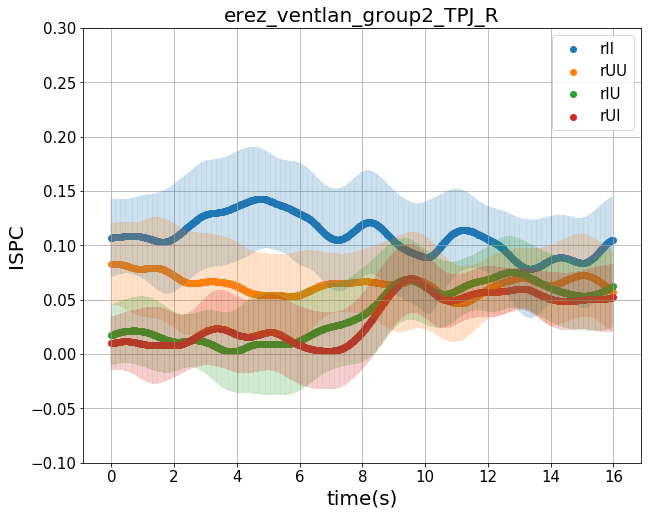

time: 607 ms


In [57]:
#visualize ISPC results with CI
mean_rII=np.mean(rII,0)
mean_rUU=np.mean(rUU,0)
mean_rIU=np.mean(rIU,0)
mean_rUI=np.mean(rUI,0)

plt.figure(figsize=(10,8))
plt.ylim(-0.1,0.3)
plt.errorbar(np.arange(lag),mean_rII, yerr=CI(0.95,rII), alpha=0.1)
plt.errorbar(np.arange(lag),mean_rUU, yerr=CI(0.95,rUU), alpha=0.1)
plt.errorbar(np.arange(lag),mean_rIU, yerr=CI(0.95,rIU), alpha=0.1)
plt.errorbar(np.arange(lag),mean_rUI, yerr=CI(0.95,rUI), alpha=0.1)
plt.grid()
plt.scatter(np.arange(lag),mean_rII,label='rII')
plt.scatter(np.arange(lag),mean_rUU,label='rUU')
plt.scatter(np.arange(lag),mean_rIU,label='rIU')
plt.scatter(np.arange(lag),mean_rUI,label='rUI')
plt.legend(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('time(s)', fontsize=20)
plt.ylabel('ISPC', fontsize=20)
plt.title(name_ROIs, fontsize=20)
plt.xticks(np.arange(0,lag+100,100),np.arange(0,18,2),fontsize=15)

plt.show()

# ISPC(AB-AC) for other ROIs (e.g. right TPJ)


In [58]:
intact_order=np.arange(25)
pair_intact=list(zip(duration_20ms,intact_order))
pair_ls=[pair_intact[j] for j in order_it2ls]

time: 18.5 ms


In [66]:
def ISPC(it_data, ls_data, start_time, end_time, pair_intact, pair_ls): #start and end time within events
    n, voxel, time=np.shape(it_data)
    ind=np.arange(n)
    r_pc_rII,r_pc_rUU,r_pc_rUI,r_pc_rIU=([]for i in range(4)) 
    rII,rUU,rUI,rIU=([]for i in range(4)) 
    duration_it=[i[0] for i in pair_intact]
    order_ls=[i[1] for i in pair_ls]
    for s in range(n):
        print('sbj:',s)
        a = ind[np.arange(len(ind))!= s]
        r_seg_rII,r_seg_rUU,r_seg_rUI,r_seg_rIU=([]for i in range(4)) 
        j=0
        i=0
        for l in intact_order[1:]:
            ind_ls=order_ls.index(l-1)+1
            if ind_ls<25:
                duration_ls = pair_ls[ind_ls][0]
                i = sum([k[0] for k in pair_intact][0:l])
                j = sum([i[0] for i in pair_ls][0:ind_ls])
                if duration_it[l] > end_time and duration_ls > end_time:
                    r=[]
                    for t in range(start_time, end_time):
                        other_rII = np.mean(it_data[a,:,i+t],0)
                        r.append(np.corrcoef(other_rII,it_data[s,:,i+t])[0][1])
                    r_seg_rII.append(r)

                    r=[]
                    for t in range(start_time, end_time):
                        other_rUU = np.mean(ls_data[a,:,j+t],0)
                        r.append(np.corrcoef(other_rUU,ls_data[s,:,j+t])[0][1])
                    r_seg_rUU.append(r)

                    r=[]
                    for t in range(start_time, end_time):
                        other_rUI = np.mean(it_data[:,:,i+t],0)
                        r.append(np.corrcoef(other_rUI,ls_data[s,:,j+t])[0][1])
                    r_seg_rUI.append(r)

                    r=[]
                    for t in range(start_time, end_time):
                        other_rIU = np.mean(ls_data[:,:,j+t],0)
                        r.append(np.corrcoef(other_rIU,it_data[s,:,i+t])[0][1])
                    r_seg_rIU.append(r)     

        rII.append(r_seg_rII)
        rUU.append(r_seg_rUU)
        rUI.append(r_seg_rUI)
        rIU.append(r_seg_rIU)

    return rII, rUU, rUI, rIU

time: 734 ms


In [67]:
ul=parsing_unscrambling(ls_aligned, 0, duration_ls)
it=parsing_unscrambling(it_aligned, 0, duration_20ms)
lag=800
rII, rUU, rUI, rIU=ISPC(it, ul, -200, lag, pair_intact, pair_ls)

KeyboardInterrupt: 

time: 6.98 s


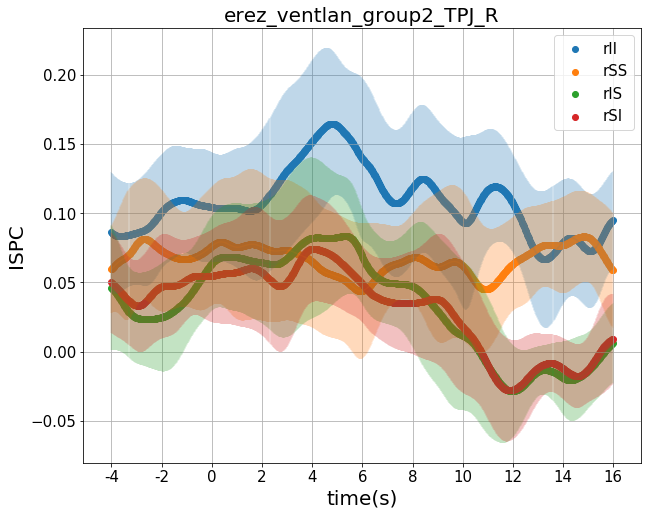

time: 770 ms


In [65]:
lag=1000
mean_rII=np.mean(rII,0)
mean_rUU=np.mean(rUU,0)
mean_rIU=np.mean(rIU,0)
mean_rUI=np.mean(rUI,0)

plt.figure(figsize=(10,8))
# plt.ylim(-0.3,0.3)
plt.errorbar(np.arange(lag),np.mean(mean_rII,0), yerr=CI(0.95,mean_rII), alpha=0.1)
plt.errorbar(np.arange(lag),np.mean(mean_rUU,0), yerr=CI(0.95,mean_rUU), alpha=0.1)
plt.errorbar(np.arange(lag),np.mean(mean_rIU,0), yerr=CI(0.95,mean_rIU), alpha=0.1)
plt.errorbar(np.arange(lag),np.mean(mean_rUI,0), yerr=CI(0.95,mean_rUI), alpha=0.1)
plt.grid()
plt.scatter(np.arange(lag),np.mean(mean_rII,0),label='rII')
plt.scatter(np.arange(lag),np.mean(mean_rUU,0),label='rSS')
plt.scatter(np.arange(lag),np.mean(mean_rIU,0),label='rIS')
plt.scatter(np.arange(lag),np.mean(mean_rUI,0),label='rSI')
plt.legend(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('time(s)', fontsize=20)
plt.ylabel('ISPC', fontsize=20)
plt.title(name_ROIs, fontsize=20)
plt.xticks(np.arange(0,lag+100,100),np.arange(-4,18,2),fontsize=15)
# plt.savefig('ISPC_rev1/%s_ISPC_rev'%name_ROIs, dpi=None, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, format='pdf',
#        transparent=False, bbox_inches=None, pad_inches=0.1,
#        frameon=None)
plt.show()